In [5]:
import numpy as np # handle arrays
import pandas as pd # data wrangling
import matplotlib.pyplot as plt # plots
import matplotlib.colors as plt_col # log color bars
import seaborn as sns # pretty plots

from scipy.optimize import curve_fit
import warnings

sns.set_theme(style="ticks",font_scale = 1.5,rc={"lines.linewidth": 2.5})

palette = sns.color_palette()

In [6]:
def hillFunc(x, K, h): # Hill sigmoidal equation from zunzun.com
    return np.power(np.log10(x), h) / (np.power(np.log10(K), h) + np.power(np.log10(x), h))

def fitHill(x,y,func=hillFunc,initial_parameters=np.array([500, 10])):
    # these are the same as the scipy defaults

    # do not print unnecessary warnings during curve_fit()
    warnings.filterwarnings("ignore")

    # curve fit the test data
    fitted_parameters, pcov = curve_fit(func, x, y, initial_parameters)

    model_predictions = func(x, *fitted_parameters) 

    abs_error = model_predictions - y

    SE = np.square(abs_error) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(abs_error) / np.var(y))

    print('Parameters:', fitted_parameters)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    
    print(fitted_parameters)
    print('IC50: ',fitted_parameters[0])
    
    return fitted_parameters

In [7]:
def plotCurves(
        dat_full=None,
        gene_name=None,
        inducer_concentrations=None,
        compound_name=None,
        compound_concentration_max=None,
        compound_rows_no_inducer=None,
        compound_rows_inducer=None,
        dilution_factor=None,
        num_dilutions=None,
        xlim=None,
        ylim=None,
        fit_scaling_coefficient=None, # these are added because otherwise the curve fitter doesn't converge
        fit_init_param=None, # these are added because otherwise the curve fitter doesn't converge
        units=None
        ):
    
    dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
    dat_full['Column'] = pd.to_numeric(dat_full['Column'])
    
    compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

    dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

    dat['Treatment'] = compound_name

    dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

    dat['IPTG_nM'] = inducer_concentrations[0]
    dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

    dat['Fraction_growth'] = 0

    for row in compound_rows_no_inducer+compound_rows_inducer:
        dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )


    plot_var = 'Fraction_growth'

    n_points_hill = int(1e3)
    x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

    x_compound = np.array(compound_concentrations*3)
    y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
    y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

    ax = sns.scatterplot(x=x_compound/fit_scaling_coefficient,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
    ax = sns.scatterplot(x=x_compound/fit_scaling_coefficient,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

    ax = sns.lineplot(x=x_hill/fit_scaling_coefficient,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=fit_init_param) ), color=palette[0]) 
    ax = sns.lineplot(x=x_hill/fit_scaling_coefficient,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=fit_init_param) ), color=palette[1]) 

    IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=fit_init_param)[0] / fitHill(x_compound,y_inducer_0,initial_parameters=fit_init_param)[0]
    print('IC50 fold change:',IC50_fold_change)

    ax.set_xscale('log')
    ax.get_legend().remove()
    ax.set_title(gene_name)
    ax.set_xlabel(compound_name+' ('+units+')')
    ax.set_ylabel('Normalized growth')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return IC50_fold_change

In [8]:
IC50_fold_changes = []

/var/folders/89/20dj8qgx0dj2z68d6fcg6_vc0000gn/T/ipykernel_17662/2024904082.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['Treatment'] = compound_name
/var/folders/89/20dj8qgx0dj2z68d6fcg6_vc0000gn/T/ipykernel_17662/2024904082.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['IPTG_nM'] = inducer_concentrations[0]
/var/folders/89/20dj8qgx0dj2z68d6fcg6_vc0000gn/T/ipykernel_17662/2024904082.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Parameters: [ 1.49170924e+04 -1.37806572e+01]
RMSE: 0.07042709103850374
R-squared: 0.9676512476733223
[ 1.49170924e+04 -1.37806572e+01]
IC50:  14917.092419782857
Parameters: [ 1.72865365e+04 -1.38062910e+01]
RMSE: 0.0659405027581161
R-squared: 0.9718858470218907
[ 1.72865365e+04 -1.38062910e+01]
IC50:  17286.5364597132
Parameters: [ 1.72865365e+04 -1.38062910e+01]
RMSE: 0.0659405027581161
R-squared: 0.9718858470218907
[ 1.72865365e+04 -1.38062910e+01]
IC50:  17286.5364597132
Parameters: [ 1.49170924e+04 -1.37806572e+01]
RMSE: 0.07042709103850374
R-squared: 0.9676512476733223
[ 1.49170924e+04 -1.37806572e+01]
IC50:  14917.092419782857
IC50 fold change: 1.1588408768446066


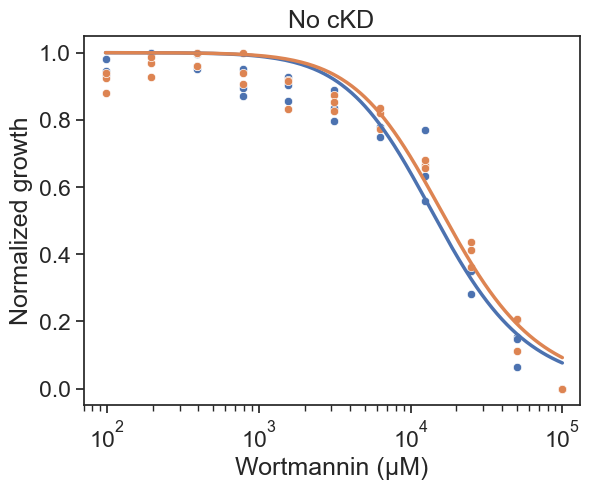

In [5]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/pPC098 wort Rluc 15sec shake 1sec int 2024.01.19 11_53_46.csv'),
    gene_name = 'No cKD',
    inducer_concentrations = [0,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

IC50_fold_changes.append( ['No cKD','NA','Wortmannin',IC50_fold_change] )

Parameters: [23588.35707929   -47.04376669]
RMSE: 0.1052454412974828
R-squared: 0.9504170837388912
[23588.35707929   -47.04376669]
IC50:  23588.35707928554
Parameters: [19148.87382881   -71.77033074]
RMSE: 0.05680536646439595
R-squared: 0.9879020380535055
[19148.87382881   -71.77033074]
IC50:  19148.873828806823
Parameters: [19148.87382881   -71.77033074]
RMSE: 0.05680536646439595
R-squared: 0.9879020380535055
[19148.87382881   -71.77033074]
IC50:  19148.873828806823
Parameters: [23588.35707929   -47.04376669]
RMSE: 0.1052454412974828
R-squared: 0.9504170837388912
[23588.35707929   -47.04376669]
IC50:  23588.35707928554
IC50 fold change: 0.811793452356319


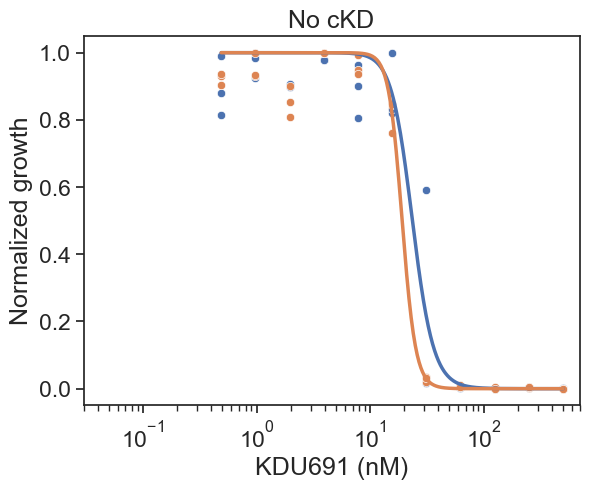

In [6]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 kdu Rluc 15sec shake 1sec int 2024.02.08 19_21_32.csv'),
    gene_name = 'No cKD',
    inducer_concentrations = [0,2],
    compound_name = 'KDU691',
    compound_concentration_max = 500000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

IC50_fold_changes.append( ['No cKD','NA','KDU691',IC50_fold_change] )

Parameters: [107.17373157 -23.38769133]
RMSE: 0.035349985557424864
R-squared: 0.9939593970418661
[107.17373157 -23.38769133]
IC50:  107.17373157142936
Parameters: [108.02400043 -28.46580086]
RMSE: 0.023216489335858813
R-squared: 0.9974362567389515
[108.02400043 -28.46580086]
IC50:  108.02400043186523
Parameters: [108.02400043 -28.46580086]
RMSE: 0.023216489335858813
R-squared: 0.9974362567389515
[108.02400043 -28.46580086]
IC50:  108.02400043186523
Parameters: [107.17373157 -23.38769133]
RMSE: 0.035349985557424864
R-squared: 0.9939593970418661
[107.17373157 -23.38769133]
IC50:  107.17373157142936
IC50 fold change: 1.007933556553167


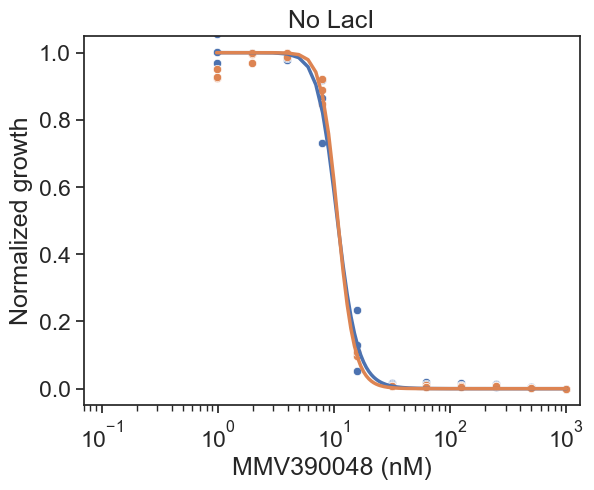

In [12]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 mmv390048 Rluc 15sec shake 1sec int 2024.02.08 19_27_26.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','A'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=10,
    fit_init_param=[1000,10],
    units='nM'
    )

IC50_fold_changes.append( ['No cKD','NA','MMV390048',IC50_fold_change] )

Parameters: [5765.36179379  -25.47733161]
RMSE: 0.059754026099966565
R-squared: 0.9810727485040809
[5765.36179379  -25.47733161]
IC50:  5765.361793789395
Parameters: [5224.10374405  -22.33203303]
RMSE: 0.055163972065557336
R-squared: 0.9859272216909482
[5224.10374405  -22.33203303]
IC50:  5224.103744046097
Parameters: [5224.10374405  -22.33203303]
RMSE: 0.055163972065557336
R-squared: 0.9859272216909482
[5224.10374405  -22.33203303]
IC50:  5224.103744046097
Parameters: [5765.36179379  -25.47733161]
RMSE: 0.059754026099966565
R-squared: 0.9810727485040809
[5765.36179379  -25.47733161]
IC50:  5765.361793789395
IC50 fold change: 0.906118979328174


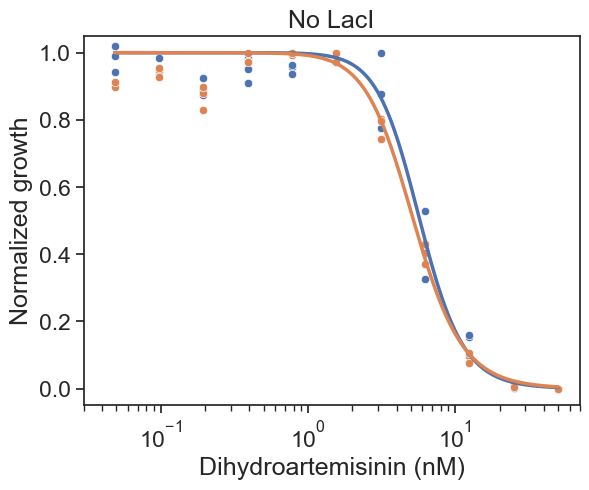

In [8]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 dha Rluc 15sec shake 1sec int 2024.02.08 19_34_07.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['No cKD','NA','Dihydroartemisinin',IC50_fold_change] )

Parameters: [10943.73853469   -29.98554614]
RMSE: 0.05895883582811189
R-squared: 0.9871894704550473
[10943.73853469   -29.98554614]
IC50:  10943.738534688811
Parameters: [10067.8607026    -33.94344118]
RMSE: 0.04747860866787166
R-squared: 0.9910757660753888
[10067.8607026    -33.94344118]
IC50:  10067.860702596303
Parameters: [10067.8607026    -33.94344118]
RMSE: 0.04747860866787166
R-squared: 0.9910757660753888
[10067.8607026    -33.94344118]
IC50:  10067.860702596303
Parameters: [10943.73853469   -29.98554614]
RMSE: 0.05895883582811189
R-squared: 0.9871894704550473
[10943.73853469   -29.98554614]
IC50:  10943.738534688811
IC50 fold change: 0.9199653912311407


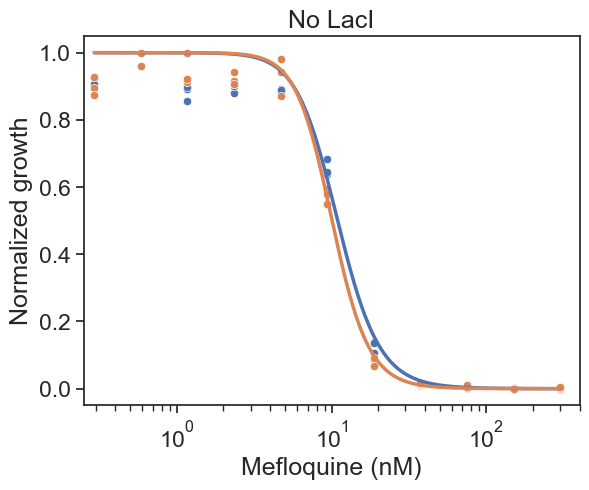

In [9]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 mq Rluc 15sec shake 1sec int 2024.02.08 19_39_21.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['No cKD','NA','Mefloquine',IC50_fold_change] )

In [10]:
# Now PI3K cKD line:

Parameters: [2165.91713624   -9.45428703]
RMSE: 0.03467128077866397
R-squared: 0.9923516043107196
[2165.91713624   -9.45428703]
IC50:  2165.9171362443667
Parameters: [10979.94420145   -12.39864802]
RMSE: 0.04868400434419509
R-squared: 0.9852179565587385
[10979.94420145   -12.39864802]
IC50:  10979.944201452086
Parameters: [10979.94420145   -12.39864802]
RMSE: 0.04868400434419509
R-squared: 0.9852179565587385
[10979.94420145   -12.39864802]
IC50:  10979.944201452086
Parameters: [2165.91713624   -9.45428703]
RMSE: 0.03467128077866397
R-squared: 0.9923516043107196
[2165.91713624   -9.45428703]
IC50:  2165.9171362443667
IC50 fold change: 5.069420255149267


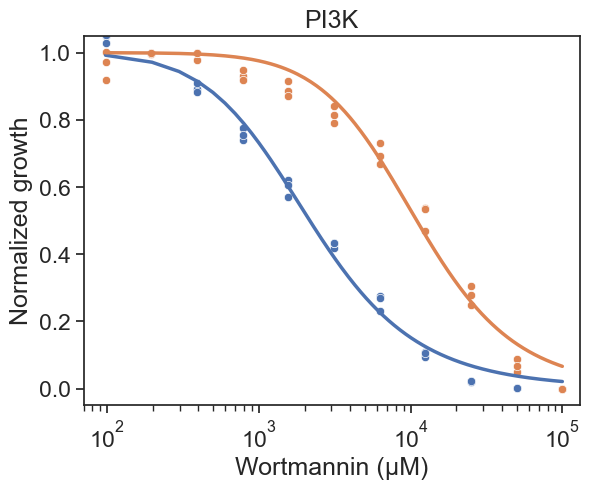

In [11]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/127 wort Rluc 15sec shake 1sec int 2023.12.13 18_08_00.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

IC50_fold_changes.append( ['LacI cKD','PI3K','Wortmannin',IC50_fold_change] )

Parameters: [15817.62506521   -42.21942924]
RMSE: 0.038085742170103104
R-squared: 0.9938657115006095
[15817.62506521   -42.21942924]
IC50:  15817.625065206765
Parameters: [17363.94477006   -65.61726479]
RMSE: 0.04872987262977868
R-squared: 0.9908400639285192
[17363.94477006   -65.61726479]
IC50:  17363.944770059472
Parameters: [17363.94477006   -65.61726479]
RMSE: 0.04872987262977868
R-squared: 0.9908400639285192
[17363.94477006   -65.61726479]
IC50:  17363.944770059472
Parameters: [15817.62506521   -42.21942924]
RMSE: 0.038085742170103104
R-squared: 0.9938657115006095
[15817.62506521   -42.21942924]
IC50:  15817.625065206765
IC50 fold change: 1.0977592842464112


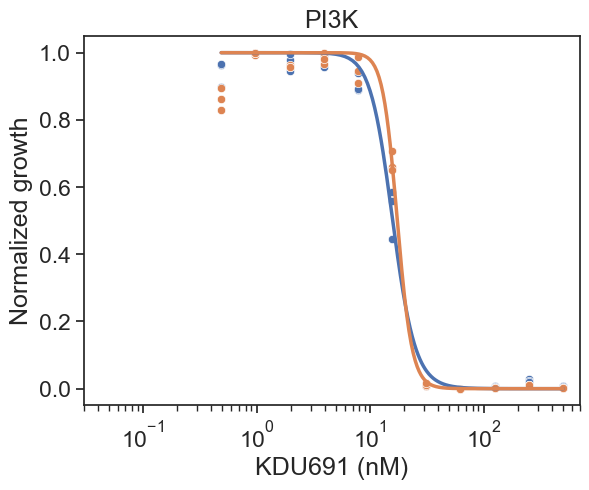

In [12]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/pablo 127 kdu Rluc 15sec shake 1sec int 2023.11.12 22_53_28.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'KDU691',
    compound_concentration_max = 500000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI3K','KDU691',IC50_fold_change] )

Parameters: [143.59674127 -14.53238939]
RMSE: 0.050928762487191366
R-squared: 0.9877252592023279
[143.59674127 -14.53238939]
IC50:  143.59674127012727
Parameters: [156.14092101 -19.83391744]
RMSE: 0.04148669239441831
R-squared: 0.9922972049552403
[156.14092101 -19.83391744]
IC50:  156.14092100524104
Parameters: [156.14092101 -19.83391744]
RMSE: 0.04148669239441831
R-squared: 0.9922972049552403
[156.14092101 -19.83391744]
IC50:  156.14092100524104
Parameters: [143.59674127 -14.53238939]
RMSE: 0.050928762487191366
R-squared: 0.9877252592023279
[143.59674127 -14.53238939]
IC50:  143.59674127012727
IC50 fold change: 1.0873569944844101


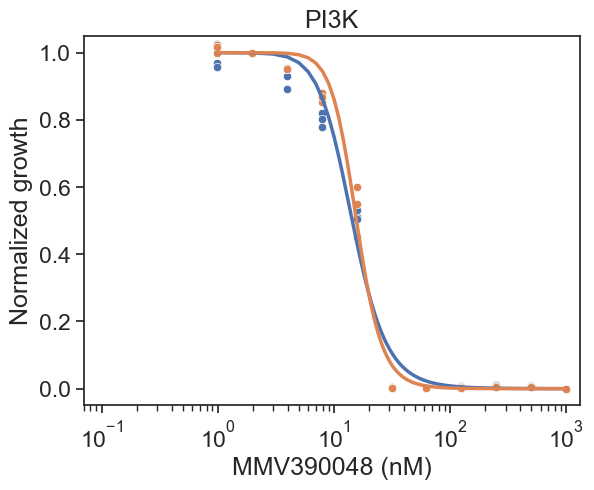

In [13]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/127 mmv390048 Rluc 15sec shake 1sec int 2024.01.16 19_33_27.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=10,
    fit_init_param=[1000,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI3K','MMV390048',IC50_fold_change] )

Parameters: [3870.98812619  -14.48487586]
RMSE: 0.0479417109224142
R-squared: 0.9895934376718241
[3870.98812619  -14.48487586]
IC50:  3870.9881261922046
Parameters: [4431.58813611  -14.75582108]
RMSE: 0.06744624235268162
R-squared: 0.9762413908483062
[4431.58813611  -14.75582108]
IC50:  4431.588136106856
Parameters: [4431.58813611  -14.75582108]
RMSE: 0.06744624235268162
R-squared: 0.9762413908483062
[4431.58813611  -14.75582108]
IC50:  4431.588136106856
Parameters: [3870.98812619  -14.48487586]
RMSE: 0.0479417109224142
R-squared: 0.9895934376718241
[3870.98812619  -14.48487586]
IC50:  3870.9881261922046
IC50 fold change: 1.1448209066107624


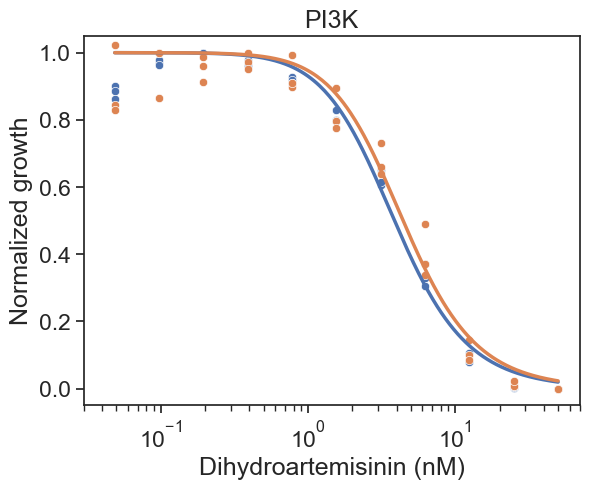

In [14]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/pablo 127 dha Rluc 15sec shake 1sec int 2023.11.12 22_08_41.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','H','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI3K','Dihydroartemisinin',IC50_fold_change] )

Parameters: [9149.05637204  -22.89567814]
RMSE: 0.03951929897096294
R-squared: 0.9924088155349878
[9149.05637204  -22.89567814]
IC50:  9149.056372043757
Parameters: [10658.19154302   -26.79537712]
RMSE: 0.03200093829926704
R-squared: 0.9953380634453178
[10658.19154302   -26.79537712]
IC50:  10658.191543020945
Parameters: [10658.19154302   -26.79537712]
RMSE: 0.03200093829926704
R-squared: 0.9953380634453178
[10658.19154302   -26.79537712]
IC50:  10658.191543020945
Parameters: [9149.05637204  -22.89567814]
RMSE: 0.03951929897096294
R-squared: 0.9924088155349878
[9149.05637204  -22.89567814]
IC50:  9149.056372043757
IC50 fold change: 1.1649498166377645


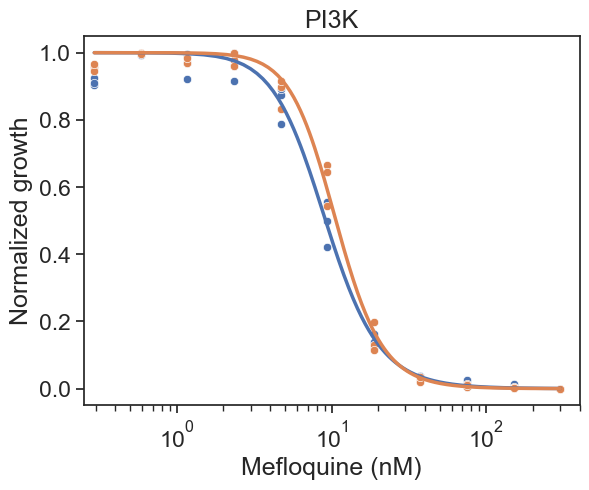

In [15]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/127 mq Rluc 15sec shake 1sec int 2023.11.27 15_15_20.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI3K','Mefloquine',IC50_fold_change] )

In [16]:
# Now PI4K cKD:

Parameters: [5470.74733286  -10.22494392]
RMSE: 0.056038916245466176
R-squared: 0.9799982367446528
[5470.74733286  -10.22494392]
IC50:  5470.747332856873
Parameters: [6306.2364381   -10.68616216]
RMSE: 0.03872450170788684
R-squared: 0.9909516637134822
[6306.2364381   -10.68616216]
IC50:  6306.236438101085
Parameters: [6306.2364381   -10.68616216]
RMSE: 0.03872450170788684
R-squared: 0.9909516637134822
[6306.2364381   -10.68616216]
IC50:  6306.236438101085
Parameters: [5470.74733286  -10.22494392]
RMSE: 0.056038916245466176
R-squared: 0.9799982367446528
[5470.74733286  -10.22494392]
IC50:  5470.747332856873
IC50 fold change: 1.1527193734988144


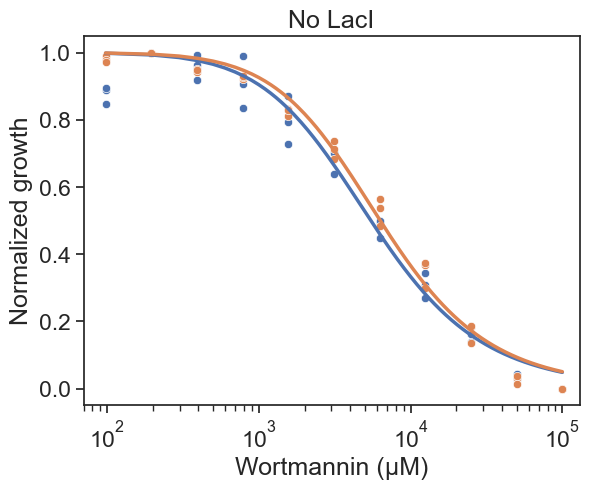

In [17]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/129 wort Rluc 15sec shake 1sec int 2023.12.13 18_35_17.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0.1,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

IC50_fold_changes.append( ['LacI cKD','PI4K','Wortmannin',IC50_fold_change] )

Parameters: [642.09171098  -9.51352571]
RMSE: 0.05665357674017486
R-squared: 0.9772826352735414
[642.09171098  -9.51352571]
IC50:  642.091710980812
Parameters: [2038.31321747  -16.83766348]
RMSE: 0.05018957726406284
R-squared: 0.9887960800286397
[2038.31321747  -16.83766348]
IC50:  2038.3132174732582
Parameters: [2038.31321747  -16.83766348]
RMSE: 0.05018957726406284
R-squared: 0.9887960800286397
[2038.31321747  -16.83766348]
IC50:  2038.3132174732582
Parameters: [642.09171098  -9.51352571]
RMSE: 0.05665357674017486
R-squared: 0.9772826352735414
[642.09171098  -9.51352571]
IC50:  642.091710980812
IC50 fold change: 3.1744892242257436


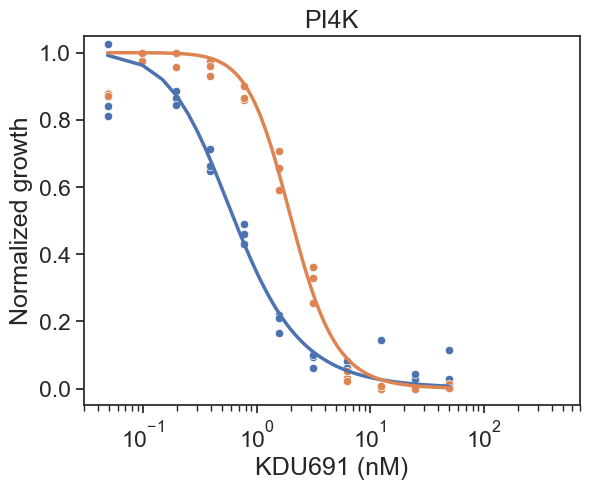

In [18]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/129 kdu Rluc 15sec shake 1sec int 2023.11.27 15_38_35.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0.04,2],
    compound_name = 'KDU691',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI4K','KDU691',IC50_fold_change] )

Parameters: [71.43312612 -8.9310839 ]
RMSE: 0.028872079299887082
R-squared: 0.9948373706975967
[71.43312612 -8.9310839 ]
IC50:  71.4331261188064
Parameters: [164.16397042 -12.93983278]
RMSE: 0.03280166309998083
R-squared: 0.9951957405985687
[164.16397042 -12.93983278]
IC50:  164.16397042105694
Parameters: [164.16397042 -12.93983278]
RMSE: 0.03280166309998083
R-squared: 0.9951957405985687
[164.16397042 -12.93983278]
IC50:  164.16397042105694
Parameters: [71.43312612 -8.9310839 ]
RMSE: 0.028872079299887082
R-squared: 0.9948373706975967
[71.43312612 -8.9310839 ]
IC50:  71.4331261188064
IC50 fold change: 2.2981490428967386


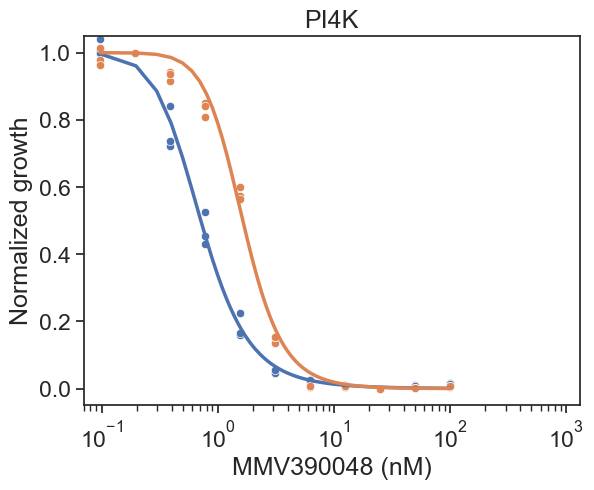

In [19]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/129 mmv390048 Rluc 15sec shake 1sec int 2024.01.16 19_45_05.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0.1,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=100,
    fit_init_param=[1000,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI4K','MMV390048',IC50_fold_change] )

Parameters: [4810.1549689  -18.6532953]
RMSE: 0.06306410051251143
R-squared: 0.9797538001591289
[4810.1549689  -18.6532953]
IC50:  4810.154968898488
Parameters: [4159.5330993   -18.69446992]
RMSE: 0.10491503501848043
R-squared: 0.9427421055501977
[4159.5330993   -18.69446992]
IC50:  4159.533099299597
Parameters: [4159.5330993   -18.69446992]
RMSE: 0.10491503501848043
R-squared: 0.9427421055501977
[4159.5330993   -18.69446992]
IC50:  4159.533099299597
Parameters: [4810.1549689  -18.6532953]
RMSE: 0.06306410051251143
R-squared: 0.9797538001591289
[4810.1549689  -18.6532953]
IC50:  4810.154968898488
IC50 fold change: 0.864739935863671


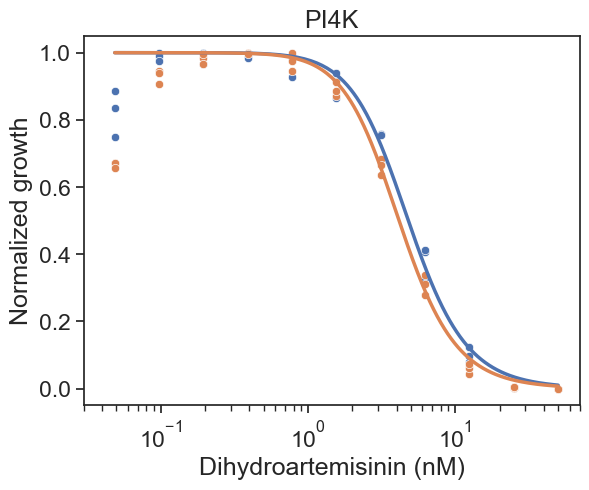

In [20]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/pablo 129 dha Rluc 15sec shake 1sec int 2023.11.12 23_03_55.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI4K','Dihydroartemisinin',IC50_fold_change] )

Parameters: [8117.10178726  -17.42821464]
RMSE: 0.05359580582148378
R-squared: 0.9867625664517367
[8117.10178726  -17.42821464]
IC50:  8117.101787262806
Parameters: [7472.69804466  -15.99185208]
RMSE: 0.06536294602077282
R-squared: 0.9787044060947473
[7472.69804466  -15.99185208]
IC50:  7472.698044657382
Parameters: [7472.69804466  -15.99185208]
RMSE: 0.06536294602077282
R-squared: 0.9787044060947473
[7472.69804466  -15.99185208]
IC50:  7472.698044657382
Parameters: [8117.10178726  -17.42821464]
RMSE: 0.05359580582148378
R-squared: 0.9867625664517367
[8117.10178726  -17.42821464]
IC50:  8117.101787262806
IC50 fold change: 0.9206115976497166


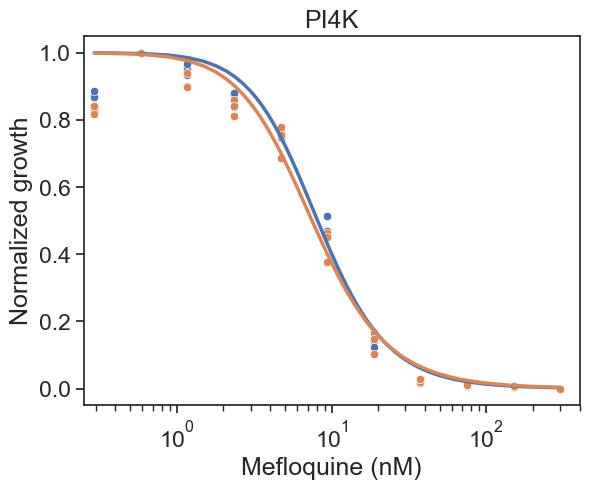

In [21]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/pablo 129 mq Rluc 15sec shake 1sec int 2023.11.12 22_20_00.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0.04,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['LacI cKD','PI4K','Mefloquine',IC50_fold_change] )

In [22]:
# TetR-DOZI construct lines
# PI3K line

Parameters: [4783.44777944  -14.4610033 ]
RMSE: 0.06245494628936852
R-squared: 0.9814862310605228
[4783.44777944  -14.4610033 ]
IC50:  4783.447779443077
Parameters: [5681.68219294  -15.5868582 ]
RMSE: 0.05186272067003249
R-squared: 0.9867772666256381
[5681.68219294  -15.5868582 ]
IC50:  5681.682192936877
Parameters: [5681.68219294  -15.5868582 ]
RMSE: 0.05186272067003249
R-squared: 0.9867772666256381
[5681.68219294  -15.5868582 ]
IC50:  5681.682192936877
Parameters: [4783.44777944  -14.4610033 ]
RMSE: 0.06245494628936852
R-squared: 0.9814862310605228
[4783.44777944  -14.4610033 ]
IC50:  4783.447779443077
IC50 fold change: 1.1877797051227303


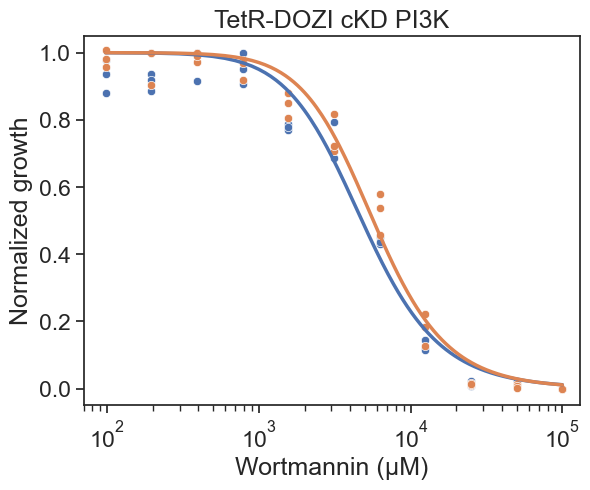

In [23]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI3K cKD/td pi3k wort Rluc 15sec shake 1sec int 2024.07.13 20_00_50.csv'),
    gene_name = 'TetR-DOZI cKD PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI3K','Wortmannin',IC50_fold_change] )

Parameters: [20555.55015053   -45.71503683]
RMSE: 0.05054304458782052
R-squared: 0.989276663499951
[20555.55015053   -45.71503683]
IC50:  20555.55015053313
Parameters: [19642.20234313   -55.61846087]
RMSE: 0.032584799137185004
R-squared: 0.9958965250845699
[19642.20234313   -55.61846087]
IC50:  19642.202343126584
Parameters: [19642.20234313   -55.61846087]
RMSE: 0.032584799137185004
R-squared: 0.9958965250845699
[19642.20234313   -55.61846087]
IC50:  19642.202343126584
Parameters: [20555.55015053   -45.71503683]
RMSE: 0.05054304458782052
R-squared: 0.989276663499951
[20555.55015053   -45.71503683]
IC50:  20555.55015053313
IC50 fold change: 0.9555668517399006


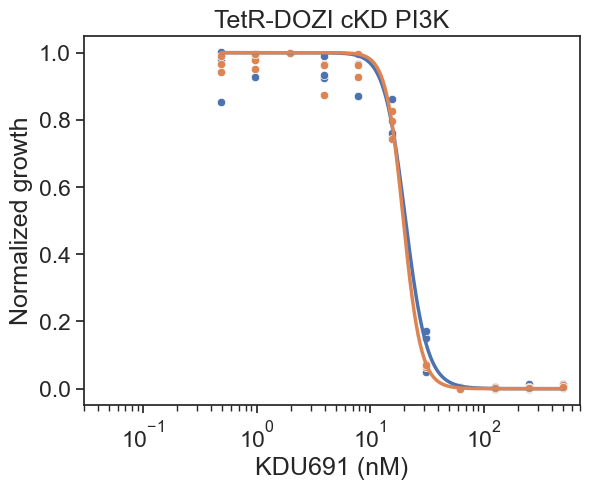

In [24]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI3K cKD/td pi3k kdu Rluc 15sec shake 1sec int 2024.07.13 20_08_53.csv'),
    gene_name = 'TetR-DOZI cKD PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'KDU691',
    compound_concentration_max = 500000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI3K','KDU691',IC50_fold_change] )

Parameters: [161.96305791 -24.94744253]
RMSE: 0.04256510898728541
R-squared: 0.9913721711993511
[161.96305791 -24.94744253]
IC50:  161.96305790953224
Parameters: [150.60290087 -16.15228192]
RMSE: 0.08106237542884874
R-squared: 0.9669891810269741
[150.60290087 -16.15228192]
IC50:  150.60290086976175
Parameters: [150.60290087 -16.15228192]
RMSE: 0.08106237542884874
R-squared: 0.9669891810269741
[150.60290087 -16.15228192]
IC50:  150.60290086976175
Parameters: [161.96305791 -24.94744253]
RMSE: 0.04256510898728541
R-squared: 0.9913721711993511
[161.96305791 -24.94744253]
IC50:  161.96305790953224
IC50 fold change: 0.9298595791756665


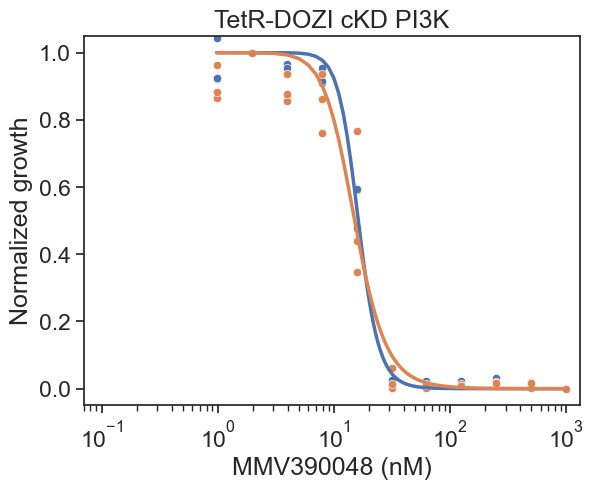

In [25]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI3K cKD/td pi3k mmv Rluc 15sec shake 1sec int 2024.07.13 20_16_58.csv'),
    gene_name = 'TetR-DOZI cKD PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=10,
    fit_init_param=[1000,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI3K','MMV390048',IC50_fold_change] )

Parameters: [4253.00192738  -26.76307477]
RMSE: 0.05977889903438388
R-squared: 0.9852145028173372
[4253.00192738  -26.76307477]
IC50:  4253.001927375348
Parameters: [3782.93166987  -23.57999257]
RMSE: 0.064320486222186
R-squared: 0.9833847524773749
[3782.93166987  -23.57999257]
IC50:  3782.931669868622
Parameters: [3782.93166987  -23.57999257]
RMSE: 0.064320486222186
R-squared: 0.9833847524773749
[3782.93166987  -23.57999257]
IC50:  3782.931669868622
Parameters: [4253.00192738  -26.76307477]
RMSE: 0.05977889903438388
R-squared: 0.9852145028173372
[4253.00192738  -26.76307477]
IC50:  4253.001927375348
IC50 fold change: 0.8894733024969919


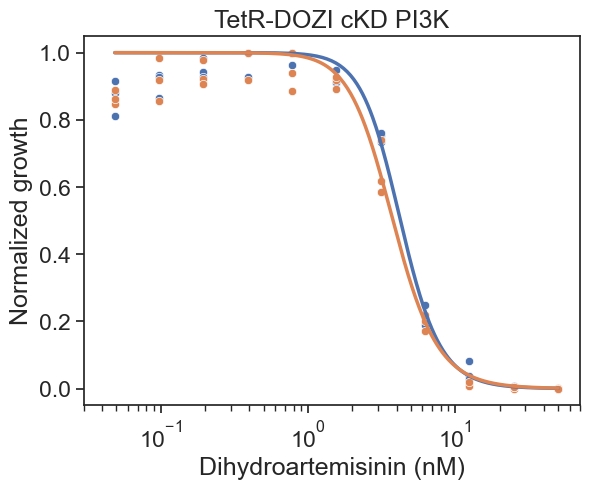

In [26]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI3K cKD/td pi3k dha Rluc 15sec shake 1sec int 2024.07.13 20_24_35.csv'),
    gene_name = 'TetR-DOZI cKD PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI3K','Dihydroartemisinin',IC50_fold_change] )

Parameters: [ 2.57148534e+04 -2.06662147e+01]
RMSE: 0.056327729024300485
R-squared: 0.9860534521264271
[ 2.57148534e+04 -2.06662147e+01]
IC50:  25714.853426002206
Parameters: [ 2.87347751e+04 -2.17002293e+01]
RMSE: 0.052745457264235636
R-squared: 0.9869422244056845
[ 2.87347751e+04 -2.17002293e+01]
IC50:  28734.775058970557
Parameters: [ 2.87347751e+04 -2.17002293e+01]
RMSE: 0.052745457264235636
R-squared: 0.9869422244056845
[ 2.87347751e+04 -2.17002293e+01]
IC50:  28734.775058970557
Parameters: [ 2.57148534e+04 -2.06662147e+01]
RMSE: 0.056327729024300485
R-squared: 0.9860534521264271
[ 2.57148534e+04 -2.06662147e+01]
IC50:  25714.853426002206
IC50 fold change: 1.1174388040615733


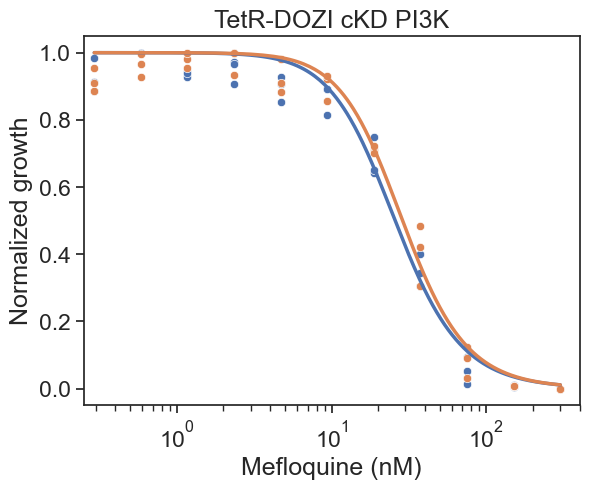

In [27]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI3K cKD/td pi3k mq Rluc 15sec shake 1sec int 2024.07.03 23_31_12.csv'),
    gene_name = 'TetR-DOZI cKD PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[3000,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI3K','Mefloquine',IC50_fold_change] )

In [28]:
# PI4K TetR-DOZI cKD

Parameters: [7142.16257832  -10.94744375]
RMSE: 0.07085626728117278
R-squared: 0.9646465018203756
[7142.16257832  -10.94744375]
IC50:  7142.162578316448
Parameters: [6191.30510723  -13.86238798]
RMSE: 0.0658024655455258
R-squared: 0.9737164846862567
[6191.30510723  -13.86238798]
IC50:  6191.305107226598
Parameters: [6191.30510723  -13.86238798]
RMSE: 0.0658024655455258
R-squared: 0.9737164846862567
[6191.30510723  -13.86238798]
IC50:  6191.305107226598
Parameters: [7142.16257832  -10.94744375]
RMSE: 0.07085626728117278
R-squared: 0.9646465018203756
[7142.16257832  -10.94744375]
IC50:  7142.162578316448
IC50 fold change: 0.8668670083236909


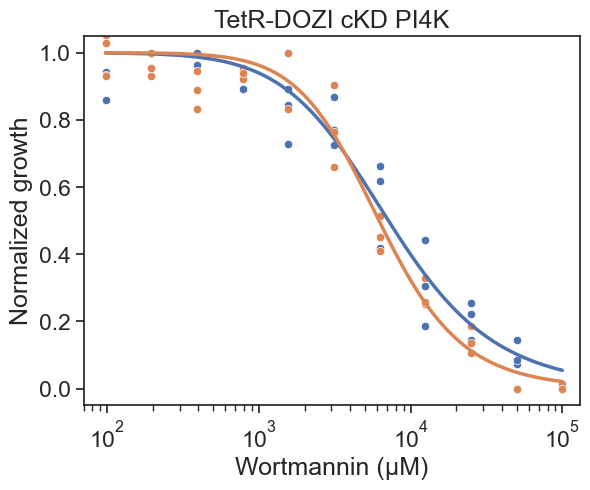

In [29]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI4K cKD/td pi4k wort Rluc 15sec shake 1sec int 2024.07.04 00_15_30.csv'),
    gene_name = 'TetR-DOZI cKD PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI4K','Wortmannin',IC50_fold_change] )

Parameters: [21808.22407395   -30.03405215]
RMSE: 0.06833496139649951
R-squared: 0.9784825228355917
[21808.22407395   -30.03405215]
IC50:  21808.224073953155
Parameters: [ 5.44597244e+04 -2.65451318e+01]
RMSE: 0.06666907397008971
R-squared: 0.9788485974543223
[ 5.44597244e+04 -2.65451318e+01]
IC50:  54459.72443943519
Parameters: [ 5.44597244e+04 -2.65451318e+01]
RMSE: 0.06666907397008971
R-squared: 0.9788485974543223
[ 5.44597244e+04 -2.65451318e+01]
IC50:  54459.72443943519
Parameters: [21808.22407395   -30.03405215]
RMSE: 0.06833496139649951
R-squared: 0.9784825228355917
[21808.22407395   -30.03405215]
IC50:  21808.224073953155
IC50 fold change: 2.4972104218462996


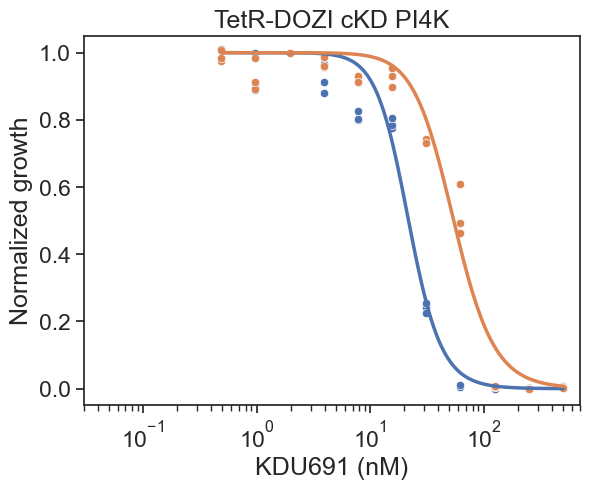

In [30]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI4K cKD/td pi4k kdu Rluc 15sec shake 1sec int 2024.07.13 20_54_09.csv'),
    gene_name = 'TetR-DOZI cKD PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'KDU691',
    compound_concentration_max = 500000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI4K','KDU691',IC50_fold_change] )

Parameters: [152.44271872 -13.96269215]
RMSE: 0.05012524505373256
R-squared: 0.9877529794956486
[152.44271872 -13.96269215]
IC50:  152.44271871839678
Parameters: [391.01533493 -15.73298609]
RMSE: 0.08330269451546798
R-squared: 0.9670563427592501
[391.01533493 -15.73298609]
IC50:  391.0153349307747
Parameters: [391.01533493 -15.73298609]
RMSE: 0.08330269451546798
R-squared: 0.9670563427592501
[391.01533493 -15.73298609]
IC50:  391.0153349307747
Parameters: [152.44271872 -13.96269215]
RMSE: 0.05012524505373256
R-squared: 0.9877529794956486
[152.44271872 -13.96269215]
IC50:  152.44271871839678
IC50 fold change: 2.5649984349405797


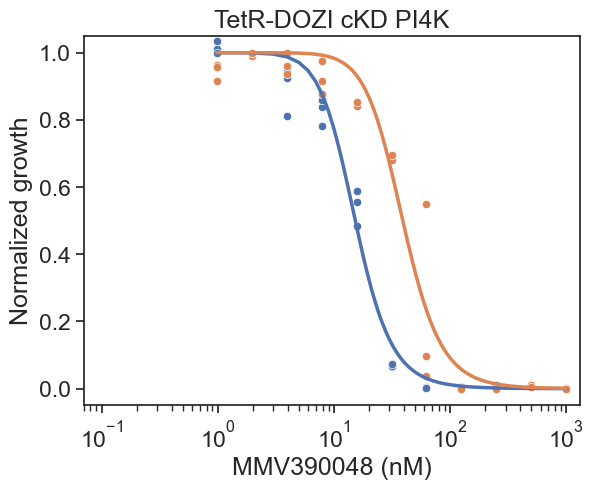

In [31]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI4K cKD/td pi4k mmv Rluc 15sec shake 1sec int 2024.07.13 21_00_39.csv'),
    gene_name = 'TetR-DOZI cKD PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=10,
    fit_init_param=[1000,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI4K','MMV390048',IC50_fold_change] )

Parameters: [3512.00066481  -28.49002476]
RMSE: 0.06642472253031918
R-squared: 0.9805220939244584
[3512.00066481  -28.49002476]
IC50:  3512.0006648119956
Parameters: [3303.57159112  -29.1095793 ]
RMSE: 0.05800523166879502
R-squared: 0.984799535217016
[3303.57159112  -29.1095793 ]
IC50:  3303.571591118751
Parameters: [3303.57159112  -29.1095793 ]
RMSE: 0.05800523166879502
R-squared: 0.984799535217016
[3303.57159112  -29.1095793 ]
IC50:  3303.571591118751
Parameters: [3512.00066481  -28.49002476]
RMSE: 0.06642472253031918
R-squared: 0.9805220939244584
[3512.00066481  -28.49002476]
IC50:  3512.0006648119956
IC50 fold change: 0.9406523251030185


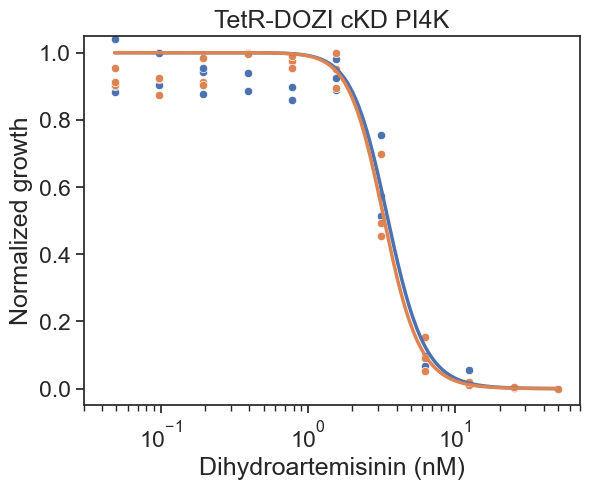

In [32]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI4K cKD/td pi4k dha Rluc 15sec shake 1sec int 2024.07.13 21_06_46.csv'),
    gene_name = 'TetR-DOZI cKD PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI4K','Dihydroartemisinin',IC50_fold_change] )

Parameters: [ 2.80659730e+04 -2.61598082e+01]
RMSE: 0.05344801173604683
R-squared: 0.9885203422701371
[ 2.80659730e+04 -2.61598082e+01]
IC50:  28065.973032042562
Parameters: [ 2.98222880e+04 -2.69320079e+01]
RMSE: 0.04176750755564181
R-squared: 0.992594874041231
[ 2.98222880e+04 -2.69320079e+01]
IC50:  29822.28797065917
Parameters: [ 2.98222880e+04 -2.69320079e+01]
RMSE: 0.04176750755564181
R-squared: 0.992594874041231
[ 2.98222880e+04 -2.69320079e+01]
IC50:  29822.28797065917
Parameters: [ 2.80659730e+04 -2.61598082e+01]
RMSE: 0.05344801173604683
R-squared: 0.9885203422701371
[ 2.80659730e+04 -2.61598082e+01]
IC50:  28065.973032042562
IC50 fold change: 1.062578088299716


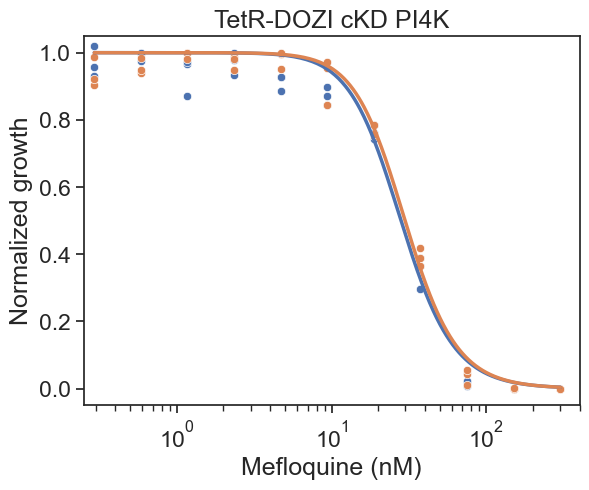

In [33]:
IC50_fold_change = plotCurves(
    dat_full = pd.read_csv('./TetR-DOZI PI4K cKD/td pi4k mq Rluc 15sec shake 1sec int 2024.07.13 20_48_15.csv'),
    gene_name = 'TetR-DOZI cKD PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[3000,10],
    units='nM'
    )

IC50_fold_changes.append( ['TetR-DOZI cKD','PI4K','Mefloquine',IC50_fold_change] )

In [34]:
IC50_fold_changes = pd.DataFrame(IC50_fold_changes, columns=['cKD','Gene','Compound','IC50'])
IC50_fold_changes['cKD_Gene'] = IC50_fold_changes['cKD'] + ', ' + IC50_fold_changes['Gene']

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Wortmannin'),
  Text(1.5, 0, 'KDU691'),
  Text(2.5, 0, 'MMV390048'),
  Text(3.5, 0, 'Dihydroartemisinin'),
  Text(4.5, 0, 'Mefloquine')])

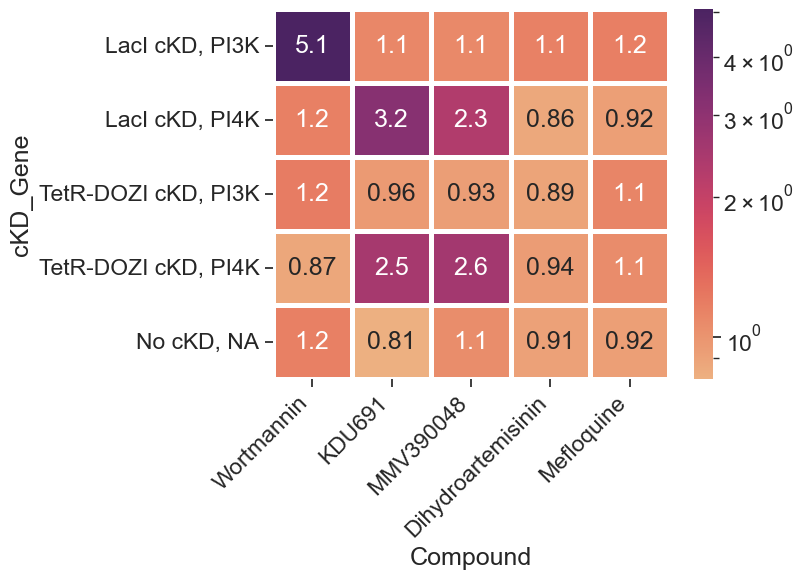

In [36]:
dat = IC50_fold_changes.pivot(index='cKD_Gene', columns='Compound', values='IC50')
dat = dat[[
    'Wortmannin','KDU691','MMV390048',
    'Dihydroartemisinin','Mefloquine'
    ]].reindex([
    'LacI cKD, PI3K','LacI cKD, PI4K',
    'TetR-DOZI cKD, PI3K','TetR-DOZI cKD, PI4K',
    'No cKD, NA',
    ])
sns.heatmap(dat, annot=True, linewidth=2.5, cmap="flare", norm=plt_col.LogNorm())
plt.xticks(rotation=45, ha='right')